# Post Process Predictions
Optimize keypoint position s.t. a set of constraints using Projected Gradient Descent.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from lightning_pose.postprocess.projected_gd import ProjectedGD
from torchtyping import TensorType
from omegaconf import DictConfig
from lightning_pose.utils.scripts import get_imgaug_transform, get_dataset, get_data_module, get_loss_factories
from lightning_pose.utils.io import return_absolute_data_paths
import hydra
import os
import pandas as pd
import cvxpy as cp
from PIL import Image

In [2]:
def MSE(preds: TensorType["num_samples", "num_keypoints",2],
        gt: TensorType["num_samples", "num_keypoints",2]):
    bp_error = torch.linalg.norm(preds - gt, dim=2) # error per keypoint-frame
    #average_error = torch.mean(bp_error, dim=1) # mean over keypoints
    return bp_error

In [3]:
def get_base_config(config_dir: str, config_name: str) -> DictConfig:
    assert(os.path.isdir(config_dir))
    hydra.initialize_config_dir(base_config_dir)
    cfg = hydra.compose(config_name="config")
    return cfg
from typing import List
def get_keypoint_names(csv_data: pd.DataFrame, header_rows: List[int]) -> List[str]:
    if header_rows == [0,1,2]:
        keypoint_names = [c[1] for c in csv_data.columns[1::2]]
    elif header_rows == [1,2]:
        keypoint_names = [c[0] for c in csv_data.columns[1::2]]
    return keypoint_names

In [4]:
dataset_name = "rick-configs-1"
# dataset_name = "ibl-pupil-2"
# dataset_name = "ibl-paw-2"
base_config_dir = "/home/jovyan/rick-configs-1"
base_save_dir = "/home/jovyan/"

# hydra.initialize_config_dir(base_config_dir)
# cfg = hydra.compose(config_name="config")
cfg = get_base_config(base_config_dir, "config")



In [5]:
# load ground truth labels
csv_file = os.path.join(cfg.data.data_dir, cfg.data.csv_file)
csv_data = pd.read_csv(csv_file, header=list(cfg.data.header_rows))
keypoints_gt = csv_data.iloc[:, 1:].to_numpy().reshape(csv_data.shape[0], -1, 2)

keypoint_names = get_keypoint_names(csv_data, cfg.data.header_rows)

In [6]:
# load pca singleview preds
pred_file = "/home/jovyan/lightning-pose/multirun/2022-03-31/01-18-42/6/predictions.csv"
#pred_file = "/home/jovyan/lightning-pose/multirun/2022-03-29/19-15-30/0/predictions.csv" # temporal + multi
#pred_file = "/home/jovyan/lightning-pose/multirun/2022-03-27/01-17-25/0/predictions.csv" # super
pred_df = pd.read_csv(pred_file, header=[0, 1, 2], index_col=0)
if pred_df.keys()[-1][0] == "set":
    # these are predictions on labeled data; get rid of last column that
    # contains info about train/val/test set
    is_video = False
    tmp = pred_df.iloc[:, :-1].to_numpy().reshape(pred_df.shape[0], -1, 3)
keypoints_pred = tmp[:, :, :2]  # shape (samples, n_keypoints, 2)
confidences = tmp[:, :, -1]  # shape (samples, n_keypoints)
print(keypoints_pred.shape)
#ground_truth_df = pd.read_csv("/datastores/mouseRunningData/CollectedData_.csv", header=[1,2])

(1045, 17, 2)


In [7]:
# save_dir = os.path.join(base_save_dir, dataset_name)
save_dir = "/home/jovyan/lightning-pose"

loss_type = "pca_singleview" # Change for different loss functions
error_metric = "reprojection_error" # for pca only
# define models
to_compute = "rmse" # rmse | pca_multiview | pca_singleview | unimodal_mse
model_name = "supervised-heatmap-75"
train_frames = 1 # used to be 75 # 000
#pca_singleview_epsilon = 15.
#pca_multiview_epsilon = None
#empirical_epsilon_multiplier = 1.0 # can hack this if want to sweep over multipliers/losses
model_type = "heatmap"
#rng_seed = 42
# temporal_epsilon = 9.8 # hack for now
#loss_weight_dict['pca_singleview'].sort(reverse=True)

pca_loss = None
datamodule = None
model_cfg = cfg.copy()
model_cfg.training.train_frames = train_frames
model_cfg.model.losses_to_use = [loss_type]
from lightning_pose.utils.pca import KeypointPCA
data_dir, video_dir = return_absolute_data_paths(data_cfg=model_cfg.data)
imgaug_transform = get_imgaug_transform(cfg=model_cfg)
dataset = get_dataset(cfg=model_cfg, data_dir=data_dir, imgaug_transform=imgaug_transform)
data_module = get_data_module(cfg=model_cfg, dataset=dataset, video_dir=video_dir)
data_module.setup()
# compute pca params
loss_factories = get_loss_factories(cfg=model_cfg, data_module=data_module)
pca_loss = loss_factories["unsupervised"].loss_instance_dict[loss_type]
# store results here
if to_compute == "pca_singleview":
    # remove obstacle keypoints
    keypoint_names = [kp for kp in keypoint_names if kp not in ['obs_top','obsHigh_bot','obsLow_bot']]
    print(keypoint_names)

metrics_collected = {bp: [] for bp in keypoint_names}
cols_collected = []

Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 836, val set: 104, test set: 105


[/opt/dali/dali/operators/reader/loader/video_loader.h:178] ``file_list_include_preceding_frame`` is set to False (or not set at all). In future releases, the default behavior would be changed to True.
[/opt/dali/dali/operators/reader/nvdecoder/nvdecoder.cc:81] Warning: Decoding on a default stream. Performance may be affected.


Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 836, val set: 104, test set: 105
Results of running PCA (pca_singleview) on keypoints:
Kept 14/28 components, and found:
Explained variance ratio: [0.354 0.247 0.17  0.063 0.056 0.031 0.02  0.015 0.008 0.008 0.008 0.005
 0.004 0.003 0.002 0.001 0.001 0.001 0.001 0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 14 components: 0.992


/home/jovyan/lightning-pose/lightning_pose/losses/losses.py:296: UserWarning: Using empirical epsilon=0.158 * multiplier=1.000 -> total=0.158 for pca_singleview loss
  warnings.warn(


In [8]:
def resize_keypoints(cfg, keypoints_pred):
    """reshape to training dims for pca losses, which are optimized for these dims"""
    x_resize = cfg.data.image_resize_dims.width
    x_og = cfg.data.image_orig_dims.width
    keypoints_pred[:, :, 0] = keypoints_pred[:, :, 0] * (x_resize / x_og)
    # put y vals back in original pixel space
    y_resize = cfg.data.image_resize_dims.height
    y_og = cfg.data.image_orig_dims.height
    keypoints_pred[:, :, 1] = keypoints_pred[:, :, 1] * (y_resize / y_og)
    return keypoints_pred

In [9]:
# resize both arrays to training dims
keypoints_pred = resize_keypoints(model_cfg, keypoints_pred)
keypoints_gt = resize_keypoints(model_cfg, keypoints_gt)

In [10]:
# remove redundant keypoints for pca singleview
#pca_cols = pca_loss.pca.columns_for_singleview_pca
keypoints_pred = pca_loss.pca._format_data(data_arr=torch.tensor(keypoints_pred).reshape(keypoints_pred.shape[0], -1))
keypoints_gt = pca_loss.pca._format_data(data_arr=torch.tensor(keypoints_gt).reshape(keypoints_gt.shape[0], -1))


In [11]:
print(keypoints_gt.shape)
print(keypoints_pred.shape)

torch.Size([1045, 28])
torch.Size([1045, 28])


## CVXPY version
* use norm on desired axis/dims. 
* reshape to go between per bodypart and per frame
* have to reshape differently just to be able to work with 2d mats always and not tensors
* 2d keypoints can be treated independently for the objective
* we just have to reshape them back to num_frames x num_keypoints for the constraints.

In [12]:
from lightning_pose.postprocess.cvxpy_optim import PostProcessorCVXPY

In [13]:
# convert pca params to numpy
pca_param_np = {}
for p_name, p_val in pca_loss.pca.parameters.items():
    if isinstance(p_val, torch.Tensor):
        pca_param_np[p_name] = p_val.detach().cpu().numpy()
    else:
        pca_param_np[p_name] = p_val

In [14]:
confidences = confidences[:, model_cfg.data.columns_for_singleview_pca]

In [15]:
confidences.reshape(-1).shape

(14630,)

In [16]:
# confidences are not used for now. 
# and we're pushing gt keypoints
post_processor = PostProcessorCVXPY(keypoints_preds=keypoints_pred.detach().cpu().numpy(), \
    confidences=None, pca_param_np=pca_param_np)
post_processor2 = PostProcessorCVXPY(keypoints_preds=keypoints_pred.detach().cpu().numpy(), \
    confidences=confidences, pca_param_np=pca_param_np)

In [17]:
prob = post_processor.build_problem()
prob2 = post_processor2.build_problem()

In [18]:
prob.solve()
prob2.solve()

4608.519194593351

In [19]:
# need to reshape those arrays, save them in new names, and plot on image
optimized_keypoints = post_processor.x.value.reshape(keypoints_pred.shape)
optimized_keypoints_reshaped = optimized_keypoints.reshape(optimized_keypoints.shape[0], -1, 2)
optimized_keypoints2 = post_processor2.x.value.reshape(keypoints_pred.shape)
optimized_keypoints_reshaped2 = optimized_keypoints2.reshape(optimized_keypoints2.shape[0], -1, 2)
keypoints_gt_reshaped = keypoints_gt.reshape(keypoints_gt.shape[0], -1, 2)
keypoints_pred_reshaped = keypoints_pred.reshape(keypoints_pred.shape[0], -1, 2)

In [20]:
eval_cond = "test"
inds_to_use = pred_df[(pred_df["set"]==eval_cond).to_numpy()].index.values

In [21]:
def scatter_and_line(gt_vector: np.ndarray, pred_vector: np.ndarray, label: str, color: str, marker: str, show_nans: bool = False):
    if show_nans:
        mask = np.arange(gt_vector[:,0].shape[0])
    else:
        mask = ~np.isnan(gt_vector[:,0])
    plt.scatter(pred_vector[mask,0], pred_vector[mask,1], c=color, label=label,marker=marker, s=15)
    for i in range(gt_vector.shape[0]):
        if ~np.isnan(gt_vector[i,0]):
            plt.plot([gt_vector[i,0], pred_vector[i,0]], [gt_vector[i,1], pred_vector[i,1]], linewidth=2.0, c=color, alpha=0.5)



In [22]:
print(optimized_keypoints_reshaped.shape)
print(optimized_keypoints_reshaped2.shape)
print(keypoints_gt_reshaped.shape)
print(keypoints_pred_reshaped.shape)

(1045, 14, 2)
(1045, 14, 2)
torch.Size([1045, 14, 2])
torch.Size([1045, 14, 2])


In [23]:
img_index = 20
img_name = csv_data.iloc[inds_to_use[img_index],0]
file_name = os.path.join(cfg.data.data_dir, img_name)
assert os.path.exists(file_name)
        # if 1 color channel, change to 3.
image = Image.open(file_name).convert("RGB")

In [24]:
assert ~np.any(confidences<0.0)

Text(0.5, 1.0, 'barObstacleScaling1/img235.png')

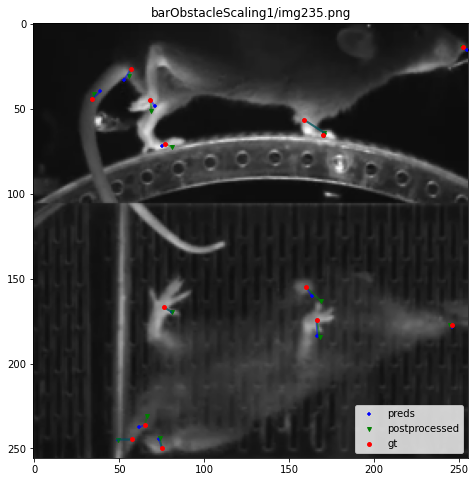

In [25]:
gt_vector = keypoints_gt_reshaped[inds_to_use[img_index],:,:].detach().cpu().numpy()
pred_vector = keypoints_pred_reshaped[inds_to_use[img_index],:,:].detach().cpu().numpy()
optimized_vector = optimized_keypoints_reshaped[inds_to_use[img_index],:,:]
optimized_vector2 = optimized_keypoints_reshaped2[inds_to_use[img_index],:,:]
plt.figure(figsize=(8,8))
plt.imshow(image.resize((256,256)))
mask = ~np.isnan(gt_vector[:,0])
scatter_and_line(gt_vector, pred_vector, label= "preds", color='b', marker="+", show_nans=False)
scatter_and_line(gt_vector, optimized_vector2, label= "postprocessed", color='g', marker="v", show_nans=False)
#scatter_and_line(gt_vector, optimized_vector, label= "postprocessed_wo_conf", color='pink', marker="^", show_nans=False)
plt.scatter(gt_vector[:,0], gt_vector[:,1], c='r', label="gt", s=15, zorder=10)
plt.legend(loc="lower right")
plt.title(img_name)
# plt.scatter(pred_vector[mask,0], pred_vector[mask,1], c='b', s=10)
# for i in range(gt_vector.shape[0]):
#     if ~np.isnan(gt_vector[i,0]):
#         plt.plot([gt_vector[i,0], pred_vector[i,0]], [gt_vector[i,1], pred_vector[i,1]], c='b', alpha=0.5)

        

In [101]:
keypoints_gt_reshaped.shape

torch.Size([1045, 14, 2])

In [42]:
x_fat = cp.reshape(post_processor2.x.T, shape=(post_processor2.orig_shape[1], post_processor2.orig_shape[0])).T
reconstruction = post_processor2.reproject_cvxpy(x=x_fat)
recon_err = post_processor2.compute_recon_error(x=x_fat, reconstruction=reconstruction)


In [79]:
less_than = recon_err.value < pca_param_np["epsilon"]
equal = np.abs(recon_err.value - pca_param_np["epsilon"]) < 1e-8
assert np.all(less_than | equal)
#assert(np.all((recon_err.value < pca_param_np["epsilon"]) or (recon_err.value == pca_param_np["epsilon"])))

In [44]:
preds_fat = cp.reshape(post_processor2.keypoints_preds_2d.T, shape=(post_processor2.orig_shape[1], post_processor2.orig_shape[0])).T
preds_reconstruction = post_processor2.reproject_cvxpy(x=preds_fat)
preds_recon_err = post_processor2.compute_recon_error(x=preds_fat, reconstruction=preds_reconstruction)


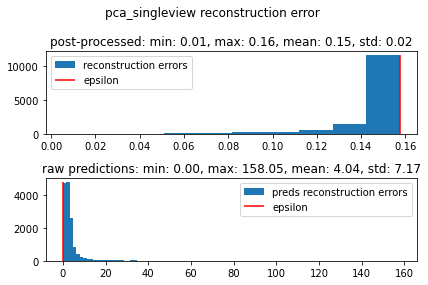

In [71]:
# compute reprojections and assert all smaller than eps
plt.suptitle("pca_singleview reconstruction error")
plt.subplot(2,1,1)
h1 = plt.hist(recon_err.value, density=False, label="reconstruction errors")
plt.vlines(x=pca_param_np["epsilon"], ymin=0, ymax=np.max(h1[0]), color="r", label="epsilon")
plt.legend()
plt.title("post-processed: min: {:.2f}, max: {:.2f}, mean: {:.2f}, std: {:.2f}".format(np.min(recon_err.value), np.max(recon_err.value), np.mean(recon_err.value), np.std(recon_err.value)))
plt.subplot(2,1,2)
h2 = plt.hist(preds_recon_err.value, bins=100, density=False, label="preds reconstruction errors")
plt.vlines(x=pca_param_np["epsilon"], ymin=0, ymax=np.max(h2[0]), color="r", label="epsilon")
plt.legend()
plt.title("raw predictions: min: {:.2f}, max: {:.2f}, mean: {:.2f}, std: {:.2f}".format(np.min(preds_recon_err.value), np.max(preds_recon_err.value), np.mean(preds_recon_err.value), np.std(preds_recon_err.value)))
plt.tight_layout()

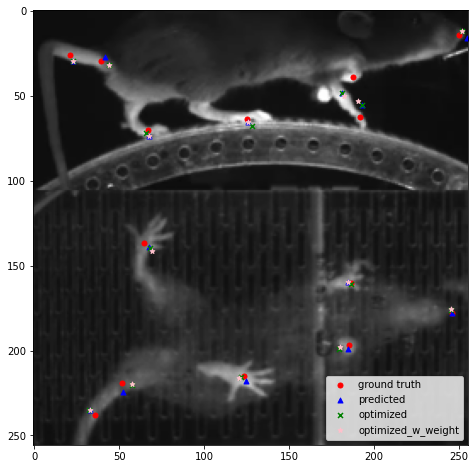

In [62]:
plt.figure(figsize=(8,8))
plt.imshow(image.resize((256,256)))
plt.scatter(keypoints_gt_reshaped[inds_to_use[img_index],:,0], keypoints_gt_reshaped[inds_to_use[img_index],:,1], s=25, c="r", label="ground truth", marker="o")
plt.scatter(keypoints_pred_reshaped[inds_to_use[img_index],:,0], keypoints_pred_reshaped[inds_to_use[img_index],:,1], s=25, c="b", label="predicted", marker="^")
plt.scatter(optimized_keypoints_reshaped[inds_to_use[img_index],:,0], optimized_keypoints_reshaped[inds_to_use[img_index],:,1], s=25, c="g", label="optimized", marker="x")
plt.scatter(optimized_keypoints_reshaped2[inds_to_use[img_index],:,0], optimized_keypoints_reshaped2[inds_to_use[img_index],:,1], s=25, c="pink", label="optimized_w_weight", marker="*")
plt.legend(loc="lower right")

### old stuff below

In [18]:
post_processor.pca_mean.shape

(28,)

In [13]:
test_arr = np.array([[0., 1., 0., 2], [0., 10., 0., 20.], [0., 100., 0., 200.]])
print(test_arr)
test_arr1 = test_arr.reshape(test_arr.shape[0], -1, 2)
test_arr_2 = test_arr.reshape(-1,2)
# can reshape directly to test_arr_2
assert(np.allclose(test_arr_2[1,:], test_arr[0, 2:]))
test_arr_3 = test_arr_2.reshape(test_arr.shape)
assert(np.allclose(test_arr_3, test_arr))

[[  0.   1.   0.   2.]
 [  0.  10.   0.  20.]
 [  0. 100.   0. 200.]]


In [49]:
keypoints_pred = keypoints_pred.detach().cpu().numpy()
keypoints_pred_2d = keypoints_pred.reshape(-1, 2) # shape (samples* n_keypoints, 2)
print(keypoints_pred_2d.shape)

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [15]:
pca_param_np.keys()

dict_keys(['mean', 'kept_eigenvectors', 'discarded_eigenvectors', 'epsilon'])

In [16]:
from typing import Dict, List, Tuple

In [25]:
def reproject_cvxpy(keypoints, evecs, mean):
    mean = np.tile(mean, (keypoints.shape[0], 1)) # for each sample, repeat mean, to broadcast
    # transform data into low-d space as in scikit learn's _BasePCA.transform()
    # https://github.com/scikit-learn/scikit-learn/blob/37ac6788c9504ee409b75e5e24ff7d86c90c2ffb/sklearn/decomposition/_base.py#L97
    centered_data = keypoints - mean
    low_d_projection = centered_data @ evecs.T

    # project back up to observation space, as in scikit learn's _BasePCA.inverse_transform()
    # https://github.com/scikit-learn/scikit-learn/blob/37ac6788c9504ee409b75e5e24ff7d86c90c2ffb/sklearn/decomposition/_base.py#L125
    reprojection = low_d_projection @ evecs + mean
    return reprojection
    
def build_pca_constraint(x: cp.Variable, keypoints_orig_shape: Tuple[int,int], pca_param_np: Dict[str, np.array]) -> List[cp.constraints.Inequality]:
    # reshape keypoints 
    #shapes = x.shape
    #out = np.prod(shapes)//2
    #test_arr_f = test_arr.T.reshape(2,out, order='F').T # that's what I should do!
    #x = cp.reshape(x.T, shape=(2, out)).T
    x = cp.reshape(x.T, shape=(keypoints_orig_shape[1], keypoints_orig_shape[0])).T
    print(x)
    # transform data into low-d space as in scikit learn's _BasePCA.transform()
    reconstruction = reproject_cvxpy(x, pca_param_np["kept_eigenvectors"], pca_param_np["mean"])
    recon_err = cp.norm(reconstruction - x, p=2, axis=1)
    return [recon_err <= pca_param_np["epsilon"]]

In [26]:
# build_pca_constraint(x=x, keypoints_orig_shape=keypoints_pred.shape, pca_param_np=pca_param_np)

In [48]:
keypoints_pred_2d = keypoints_pred.reshape(-1, 2) # shape (samples* n_keypoints, 2)

x = cp.Variable(keypoints_pred_2d.shape)
print(x)
#x.value = keypoints_pred_2d.detach().cpu().numpy() # doesn't seem to matter
weights = confidences.reshape(keypoints_pred_2d.shape) #np.ones(shape=(keypoints_pred_2d.shape[0],)) # in the future use actual vals

norm = cp.norm(x - keypoints_pred_2d, p=2, axis=1)
# sum the weighted norms over the samples and keypoints
objective = cp.Minimize(cp.sum(cp.multiply(weights, norm)))

constraints = build_pca_constraint(x=x, keypoints_orig_shape=keypoints_pred.shape, pca_param_np=pca_param_np)

prob = cp.Problem(objective, constraints)
print(prob)

print("Optimal value", prob.solve())
print("Optimal var")
print(x.value) # A numpy ndarray.


var84


ValueError: cannot reshape array of size 17765 into shape (14630,2)

In [28]:
print("Optimal value", prob.solve())

Optimal value 123356.9091458245


In [29]:
optimized_keypoints = x.value.reshape(keypoints_pred.shape)

In [30]:
optimized_keypoints.shape

(1045, 28)

In [31]:
pred_df["set"].columns.to_flat_index()
#pred_df[pred_df["set"]=="train"]

Index([('Unnamed: 52_level_1', 'Unnamed: 52_level_2')], dtype='object')

In [32]:
eval_cond = "test"
inds_to_use = pred_df[(pred_df["set"]==eval_cond).to_numpy()].index.values

In [39]:
img_name = csv_data.iloc[inds_to_use[0],0]#["image_name"]
img_name

'barObstacleScaling1/img10.png'

In [33]:
from PIL import Image

In [35]:
keypoints_gt = keypoints_gt.reshape(keypoints_gt.shape[0], -1, 2)
keypoints_pred = keypoints_pred.reshape(keypoints_pred.shape[0], -1, 2)

In [36]:
optimized_keypoints = optimized_keypoints.reshape(optimized_keypoints.shape[0], -1, 2)

In [37]:
print(optimized_keypoints.shape)
print(keypoints_pred.shape)
print(keypoints_gt.shape)

(1045, 14, 2)
(1045, 14, 2)
torch.Size([1045, 14, 2])


In [45]:
img_index = 16
img_name = csv_data.iloc[inds_to_use[img_index],0]
file_name = os.path.join(cfg.data.data_dir, img_name)
assert os.path.exists(file_name)
        # if 1 color channel, change to 3.
image = Image.open(file_name).convert("RGB")


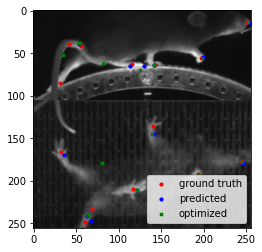

In [46]:
plt.imshow(image.resize((256,256)))
plt.scatter(keypoints_gt[inds_to_use[img_index],:,0], keypoints_gt[inds_to_use[img_index],:,1], s=10, c="r", label="ground truth")
plt.scatter(keypoints_pred[inds_to_use[img_index],:,0], keypoints_pred[inds_to_use[img_index],:,1], s=10, c="b", label="predicted")
plt.scatter(optimized_keypoints[inds_to_use[img_index],:,0], optimized_keypoints[inds_to_use[img_index],:,1], s=10, c="g", label="optimized", marker="x")
plt.legend(loc="lower right")
#plt.savefig('/home/jovyan/figs/first_cvxpy_optim.png')


In [26]:
pred_df["set"].index.values
#pred_df[pred_df.set=="test"]

array([   0,    1,    2, ..., 1042, 1043, 1044])

In [21]:
from lightning_pose.data.utils import DataExtractor

In [22]:
keypoints_tensor, images_tensor = DataExtractor(data_module=data_module, cond="test", extract_images=True)()

In [24]:
keypoints_tensor.shape

torch.Size([105, 34])

In [24]:
(2,3)

AttributeError: 'tuple' object has no attribute 'T'

In [102]:
# test reshaping
test_arr = np.array([[0., 1., 0., 2], [0., 10., 0., 20.], [0., 100., 0., 200.]])
print(test_arr)
test_arr1 = test_arr.reshape(test_arr.shape[0], -1, 2)
test_arr_2 = test_arr.reshape(-1,2)
# can reshape directly to test_arr_2
assert(np.allclose(test_arr_2[1,:], test_arr[0, 2:]))
test_arr_3 = test_arr_2.reshape(test_arr.shape)
assert(np.allclose(test_arr_3, test_arr))

[[  0.   1.   0.   2.]
 [  0.  10.   0.  20.]
 [  0. 100.   0. 200.]]


In [105]:
norm = cp.norm(test_arr_2, p=2, axis=1)
norm.shape

(6,)

In [106]:
norm.value

array([  1.,   2.,  10.,  20., 100., 200.])

In [109]:
# invert the shape order, have two transposes
cp.reshape(norm.T, shape=(2,3)).T.value

array([[  1.,   2.],
       [ 10.,  20.],
       [100., 200.]])

In [112]:
cp.reshape(test_arr.T, shape=(2,6)).T.value

array([[  0.,   1.],
       [  0.,   2.],
       [  0.,  10.],
       [  0.,  20.],
       [  0., 100.],
       [  0., 200.]])